# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.layers import TimeDistributed, ConvLSTM2D, Conv3D
from tensorflow.keras.models import Model, Sequential

The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimension 64x64.

Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [2]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train, validation and test sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) : int(0.9 * dataset.shape[0])]
test_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
test_dataset = dataset[test_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255
test_dataset = test_dataset / 255

# Define the generator.
def generator(dataset, batch_size=16, seqlen=4):
    while True:
        batch_x = np.zeros((batch_size, seqlen-1, 64, 64, 1))
        batch_y = np.zeros((batch_size, seqlen-1, 64, 64, 1))
        ran = np.random.randint(dataset.shape[0],size=batch_size)
        minibatch = dataset[ran]
        for i in range(batch_size):
            random_start = np.random.randint(0,20-seqlen)
            random_end = random_start+seqlen-1
            batch_x[i] = minibatch[i, random_start : random_end, :, :]
            batch_y[i] = minibatch[i, random_start+1 : random_end+1, :, :]
        yield(batch_x, batch_y)

# Apply the generator to the datasets.
train_gen = generator(train_dataset)
val_gen = generator(val_dataset)
test_gen = generator(test_dataset)

# Inspect the generators.
print(f"Train Dataset Shapes: {train_dataset.shape[0]} samples, input:{next(train_gen)[0].shape}, output:{next(train_gen)[1].shape}")
print(f"Validation Dataset Shapes: {val_dataset.shape[0]} samples, input:{next(val_gen)[0].shape}, output:{next(val_gen)[1].shape}")
print(f"Test Dataset Shapes: {test_dataset.shape[0]} samples, input:{next(test_gen)[0].shape}, output:{next(test_gen)[1].shape}")

819200096/819200096 [==============================] - 119s 0us/step
Train Dataset Shapes: 8000 samples, input:(16, 3, 64, 64, 1), output:(16, 3, 64, 64, 1)
Validation Dataset Shapes: 1000 samples, input:(16, 3, 64, 64, 1), output:(16, 3, 64, 64, 1)
Test Dataset Shapes: 1000 samples, input:(16, 3, 64, 64, 1), output:(16, 3, 64, 64, 1)


## Data Visualization


Displaying example frames


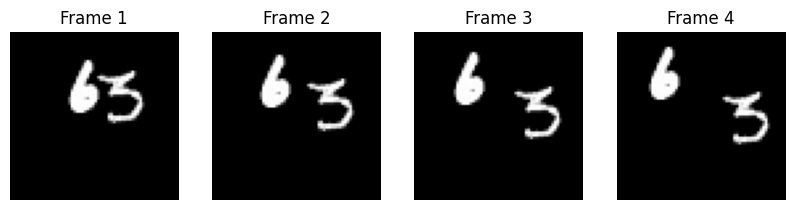

In [3]:
gen_example = generator(train_dataset, batch_size=1, seqlen=4)
sample_x, sample_y = next(gen_example)

def show_frames(x, y, s):
    # Construct a figure on which we will visualize the images.
    fig, axes = plt.subplots(1, 4, figsize=(10, 5))

    for idx, ax in enumerate(axes.flat):
        if(idx < 3):
            ax.imshow(x[0][idx], cmap="gray")
            ax.set_title(f"Frame {idx + 1}")
            ax.axis("off")
        else:
            ax.imshow(y[0][idx-1], cmap="gray")
            ax.set_title(f"Frame {idx + 1}")
            ax.axis("off")

    # Print information and display the figure.
    print(f"\nDisplaying {s} frames")
    plt.show()

show_frames(sample_x, sample_y, "example")

# What to deliver

As usual you are supposed to deliver a single notebook, sufficiently documented.
Do not erase the output cell of your notebook after the last execution. Especially, leave a sufficently verbose trace of training.

As already stated, the model must be evalauted on the full test set.

# Good work!

## Model Construction

To build the model, we will use `ConvLSTM2D` layers for the encoder part, and `Time Distributed Conv2DTranspose` for the decoder part, and return the predicted frame with a `Conv3D layer`.

In [4]:
import keras.backend as K

def convolution_operation(entered_input, filters=64, kernel_size=3):
    # Taking input and implementing the conv block
    conv1 = ConvLSTM2D(filters, kernel_size, padding = "same",
                       return_sequences = True, activation = "relu")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    return batch_norm1

def encoder(entered_input, filters=64, kernel_size=3):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters, kernel_size)
    MaxPool1 = TimeDistributed(
        MaxPooling2D(strides = (2,2))
    )(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64, kernel_size=3):
    # Upsampling and concatenating the essential features
    Upsample = TimeDistributed(
        Conv2DTranspose(filters, kernel_size, strides = 2, padding = "same")
        )(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def mse_on_predicted_frame(y_true, y_pred):
    return K.mean(K.square(y_true[:,-1,:,:,:] - y_pred[:,-1,:,:,:]))

The loss function of the model is the MSE function provided by Keras, while the metrics is a local function that calculate the Mean Squared Error only for the predicted frame (so the last frame of the output array)

In [5]:
input_shape = (None, *next(train_gen)[0].shape[2:])
# Take the image shape
input = Input(input_shape)

# Construct the encoder blocks
skip1, encoder_1 = encoder(input, 64, 3)
skip2, encoder_2 = encoder(encoder_1, 64*2, 3)
skip3, encoder_3 = encoder(encoder_2, 64*4, 3)

# Preparing the next block
conv_block = convolution_operation(encoder_3, 64*8, 3)

# Construct the decoder blocks
decoder_2 = decoder(conv_block, skip3, 64*4, 2)
decoder_3 = decoder(decoder_2, skip2, 64*2, 2)
decoder_4 = decoder(decoder_3, skip1, 64, 2)

# Construct the output block
out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(decoder_4)

# Create and compile the model
model = Model(input, out)
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(),
    metrics=[mse_on_predicted_frame]
)
# Show the summary and the total parameters of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, None, 64, 64  150016      ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 64, 64  256        ['conv_lstm2d[0][0]']            
 alization)                     , 64)                                                         

## Model Training

With our model and data constructed, we can now train the model.

In [6]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 16

# Fit the model to the training data.
model.fit(
    train_gen,
    steps_per_epoch=len(train_dataset) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_dataset) // batch_size,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
500/500 [==============================] - 364s 649ms/step - loss: 0.0094 - mse_on_predicted_frame: 0.0218 - val_loss: 0.0256 - val_mse_on_predicted_frame: 0.0384 - lr: 0.0010
Epoch 2/30
500/500 [==============================] - 331s 661ms/step - loss: 0.0052 - mse_on_predicted_frame: 0.0152 - val_loss: 0.0047 - val_mse_on_predicted_frame: 0.0137 - lr: 0.0010
Epoch 3/30
500/500 [==============================] - 330s 660ms/step - loss: 0.0043 - mse_on_predicted_frame: 0.0125 - val_loss: 0.0040 - val_mse_on_predicted_frame: 0.0116 - lr: 0.0010
Epoch 4/30
500/500 [==============================] - 330s 660ms/step - loss: 0.0037 - mse_on_predicted_frame: 0.0109 - val_loss: 0.0037 - val_mse_on_predicted_frame: 0.0107 - lr: 0.0010
Epoch 5/30
500/500 [==============================] - 322s 644ms/step - loss: 0.0034 - mse_on_predicted_frame: 0.0100 - val_loss: 0.0034 - val_mse_on_predicted_frame: 0.0101 - lr: 0.0010
Epoch 6/30
500/500 [==============================] - 330s 659ms/

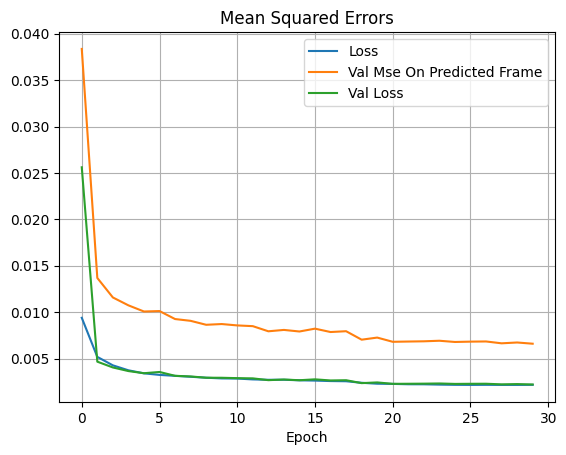

In [7]:
# Check overfit
loss_history = model.history.history['loss']
val_mse_on_predicted_frame_history = model.history.history['val_mse_on_predicted_frame']
val_loss_history = model.history.history['val_loss']

plt.plot(loss_history)
plt.plot(val_mse_on_predicted_frame_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Mse On Predicted Frame', 'Val Loss'])
plt.title('Mean Squared Errors')
plt.show()

## Frame Prediction Visualizations

1/1 [==============================] - 2s 2s/step

Displaying test frames


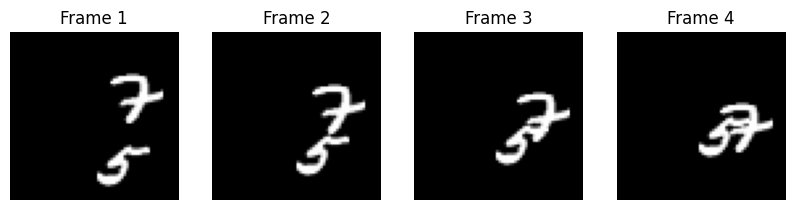


Displaying predicted frames


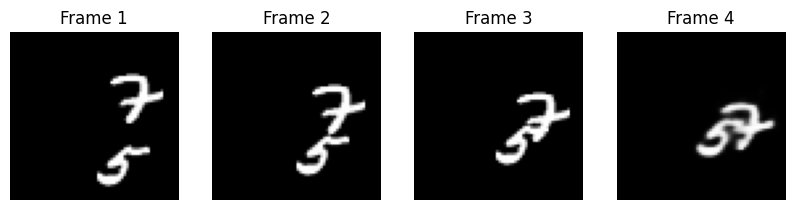

1/1 [==============================] - 0s 54ms/step - loss: 0.0016 - mse_on_predicted_frame: 0.0048

MSE score on the predicted example: 0.0048005953431129456


In [8]:
# Plot each of the sequential images for a data prediction
test_gen = generator(test_dataset, batch_size=1, seqlen=4)
test_x, test_y = next(test_gen)
prediction_y = model.predict(test_x)

show_frames(test_x, test_y, "test")

show_frames(test_x, prediction_y, "predicted")

pred_score = model.evaluate(test_x, test_y)
print(f"\nMSE score on the predicted example: {pred_score[1]}")

In [9]:
score = model.evaluate(test_gen, steps=len(test_dataset))
print(f"\nMSE score on the full test set: {score[1]}")

1000/1000 [==============================] - 36s 36ms/step - loss: 0.0022 - mse_on_predicted_frame: 0.0065

MSE score on the full test set: 0.0065086642280220985
